Timeseries anomaly detection using an Autoencoder
Goals:
* To use a reconstruction convolutional autoencoder model to detect anomalies in timeseries data.
* Use the Numenta Anomaly Benchmark(NAB) dataset. 
* It contains artifical timeseries data containing labeled anomalous periods of behavior. 
* Data are ordered, timestamped, single-valued metrics.
* Use the art_daily_small_noise.csv file for training and the art_daily_jumpsup.csv file for testing.

In [1]:
# import libraries
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [2]:
# Load the data
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)


In [5]:
# Review the loaded data
print("Train Data: \n")
print(df_small_noise.head())
print("\n Test Data: \n")
print(df_daily_jumpsup.head())

Train Data: 

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120

 Test Data: 

                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


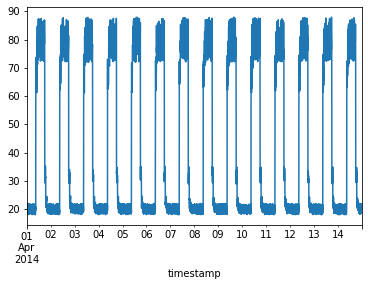

In [6]:
# Visualize the data
# Timeseries data without anomalies

fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

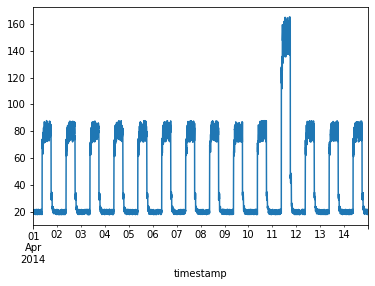

In [7]:
# Visualize the data
# Timeseries data with anomalies
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [8]:
# Prepare training data
# Read data from the df_small_noise training timeseries data and normalize the value data. 
# Get a value for every 5 mins for 14 days.
# 24 * 60 / 5 = 288 timesteps per day
# 288 * 14 = 4032 data points in total
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [9]:
# Create sequences
# Create sequences combining TIME_STEPS contiguous data values from the training data.
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)
# start at 0 to 287 as one step
# 3745+287 = 4032

Training input shape:  (3745, 288, 1)


Build a model
* Build a convolutional reconstruction autoencoder model. 
* The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape. 
* In this case, sequence_length is 288 and num_features is 1.

In [14]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [15]:
# Train the model
# Use x_train as both the input and the target since this is a reconstruction model.
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
    ],
    verbose = 2
)


Epoch 1/50
27/27 - 2s - loss: 0.5813 - val_loss: 0.0909 - 2s/epoch - 58ms/step
Epoch 2/50
27/27 - 0s - loss: 0.0887 - val_loss: 0.0413 - 488ms/epoch - 18ms/step
Epoch 3/50
27/27 - 0s - loss: 0.0570 - val_loss: 0.0358 - 464ms/epoch - 17ms/step
Epoch 4/50
27/27 - 1s - loss: 0.0465 - val_loss: 0.0298 - 505ms/epoch - 19ms/step
Epoch 5/50
27/27 - 1s - loss: 0.0397 - val_loss: 0.0277 - 505ms/epoch - 19ms/step
Epoch 6/50
27/27 - 1s - loss: 0.0352 - val_loss: 0.0285 - 501ms/epoch - 19ms/step
Epoch 7/50
27/27 - 1s - loss: 0.0320 - val_loss: 0.0291 - 532ms/epoch - 20ms/step
Epoch 8/50
27/27 - 1s - loss: 0.0293 - val_loss: 0.0286 - 526ms/epoch - 19ms/step
Epoch 9/50
27/27 - 1s - loss: 0.0270 - val_loss: 0.0289 - 531ms/epoch - 20ms/step
Epoch 10/50
27/27 - 1s - loss: 0.0252 - val_loss: 0.0295 - 535ms/epoch - 20ms/step


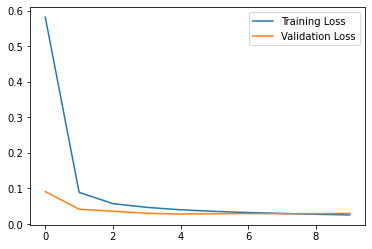

In [16]:
# Plot training & validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detect Anomolies
Detect anomalies by determining how well our model can reconstruct the input data.
* Find MAE loss on training samples.
* Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. Make this the threshold for anomaly detection.
* If the reconstruction loss for a sample is greater than this threshold value then infer that the model is seeing a pattern that it isn't familiar with. 

118/118 [==============================] - 1s 5ms/step


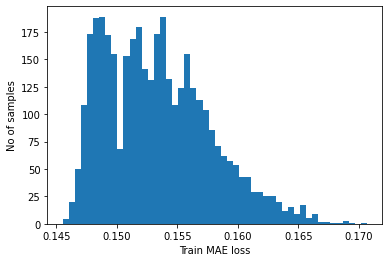

Reconstruction error threshold:  0.17065862999693784


In [17]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

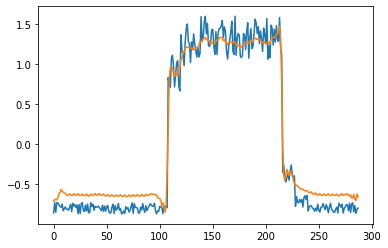

In [18]:
# Compare a reconstruction
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

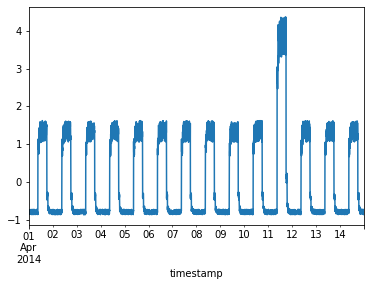

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 1s 4ms/step


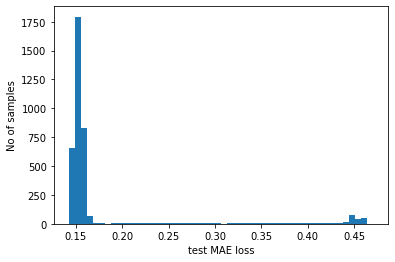

Number of anomaly samples:  393
Indices of anomaly samples:  (array([2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712,
       2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723,
       2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734,
       2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745,
       2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756,
       2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767,
       2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778,
       2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789,
       2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800,
       2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811,
       2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822,
       2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833,
       2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2

In [19]:
# Prepare test data
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

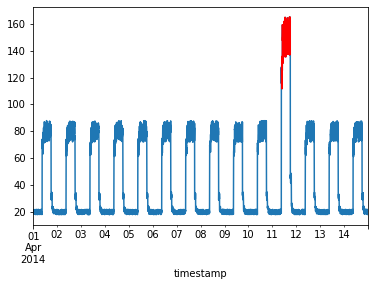

In [20]:
# Plot anomalies
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

Reference:
* https://keras.io/examples/timeseries/timeseries_anomaly_detection/